# Salary and Education in Wisconsin

This notebook is intended to describe analysis on salaries of teachers within the Wisconsin Department of Public Instruction.

## Preparation

### Load libraries
Only needed to load data to BigQuery

In [0]:
!pip install gcsfs
!pip install pandas-gbq -U
import gcsfs

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery

In [0]:
%matplotlib inline
plt.style.use('bmh')

In [0]:
project_id='wi-dpi-010'
raw_data_bucket_name='landing-009'
source_name='all_staff_report'
year='2017_2018'
filename='AllStaffReportPublic__04152019_194414.csv'
full_filename=raw_data_bucket_name + '/' + source_name + '/' + year + '/' + filename

dataset_name='landing'
table_name=source_name
landing_bq_fullname=dataset_name + '.' + table_name



### Functions

In [0]:
def create_dataset(client, project_id, dataset_name):
  
  
  dataset_id = "{}.{}".format(project_id, dataset_name)
  dataset = bigquery.Dataset(dataset_id)
  dataset.location = "US"

  dataset = client.create_dataset(dataset)
  print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

In [0]:
def convert_currency(val):
    """
    Convert the string number value to a float
     - Remove $
     - Remove commas
     - Convert to float type
    """
    new_val = val.replace(',','').replace('$', '')
    return float(new_val)

### Load Data

Data can be retrieved from the GCP Bucket.

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
client = bigquery.Client(project_id)

In [0]:
create_dataset(client, project_id, dataset_name)

In [0]:
fs = gcsfs.GCSFileSystem(project=project_id)
with fs.open(full_filename) as f:
  df = pd.read_csv(f, skiprows=1)

In [0]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.to_gbq(landing_bq_fullname,project_id=project_id,if_exists='replace')

# Exploratory Data Analysis

The following fields are Integers; but have Nulls in the columns. 

As such they are loaded as floats:

1.  entity_id
2.  assignment_work_cesa_number
3.  district_mailing_po_box


In [0]:
query = '''
  SELECT
    *
  FROM
    [{project}.{dataset}.{table}]
 '''.format(project=project_id, dataset=dataset_name, table=table_name)

In [0]:
df = pd.io.gbq.read_gbq(query, project_id=project_id, reauth=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [0]:
df.head()

In [0]:
df.info()

In [0]:
# df.count() does not include NaN values
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
#del df2['Id']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2

In [0]:
df['total_salary'] = df['total_salary'].apply(lambda x: convert_currency(x) if pd.notnull(x) else x)
df['total_fringe'] = df['total_fringe'].apply(lambda x: convert_currency(x) if pd.notnull(x) else x)


In [0]:
print(df['total_salary'].describe())
plt.figure(figsize=(9, 8))
#sns.distplot(df['total_salary'], color='g', bins=100);
sns.distplot(df['total_salary'], color='g', bins=100, hist_kws={'alpha': 0.4})

In [0]:
print(df['total_fringe'].describe())
plt.figure(figsize=(9, 8))
#sns.distplot(df['total_salary'], color='g', bins=100);
sns.distplot(df['total_fringe'], color='g', bins=100, hist_kws={'alpha': 0.4})

In [0]:
print(df['total_salary'].describe())
plt.figure(figsize=(9, 8))
#sns.distplot(df['total_salary'], color='g', bins=100);
sns.distplot(df['total_salary'], color='g', bins=100, hist_kws={'alpha': 0.4})

In [0]:
df['total_compensation']=df['total_salary']+df['total_fringe']

In [0]:
print(df['total_compensation'].describe())
plt.figure(figsize=(9, 8))
#sns.distplot(df['total_salary'], color='g', bins=100);
sns.distplot(df['total_compensation'], color='g', bins=100, hist_kws={'alpha': 0.4})

In [18]:
list(set(df.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [19]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,research_id,school_year,entity_id,birth_year,contract_days,contract_local_experience,contract_total_experience,total_salary,total_fringe,assignment_work_cesa_number,assignment_fte,school_mailing_zip_code,district_mailing_zip_code,total_compensation
0,90313,2018,673393.0,1948,NaN,NaN,NaN,NaN,NaN,7.0,NaN,54115.0,54115,NaN
1,23255,2018,440950.0,1967,NaN,NaN,NaN,NaN,NaN,7.0,NaN,54115.0,54115,NaN
2,148857,2018,808929.0,1971,NaN,NaN,NaN,NaN,NaN,7.0,NaN,54115.0,54115,NaN
3,78347,2018,57697.0,1951,NaN,NaN,NaN,NaN,NaN,7.0,NaN,54115.0,54115,NaN
4,40518,2018,53515.0,1969,NaN,NaN,NaN,NaN,NaN,7.0,NaN,54115.0,54115,NaN


In [0]:
df_num = df_num[['birth_year','contract_days','assignment_fte','contract_local_experience','contract_total_experience']]

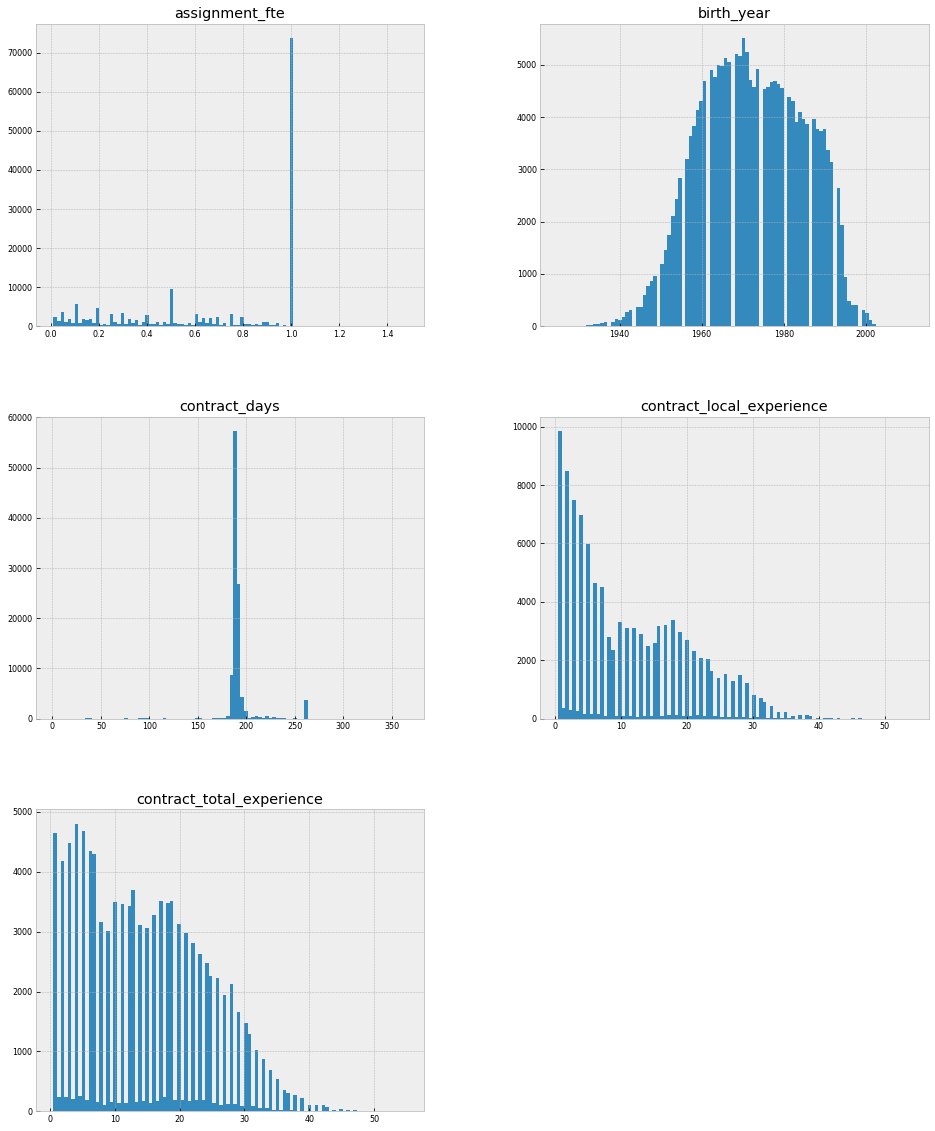

In [24]:
df_num.hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8);

In [0]:
query = '''
SELECT
  research_id,
  school_year,
  lower(last_name) as lname,
  lower(first_name) as fname,
  gender,
  raceethnicity,
  birth_year,
  contract_high_degree,
  contract_local_experience,
  contract_total_experience,
  total_salary,
  total_fringe,
  sum(assignment_fte) as total_fte
FROM [{project}.{dataset}.{table}]
WHERE
  position_classification = 'Teachers'
GROUP BY
  research_id,
  school_year,
  lname,
  fname,
  gender,
  raceethnicity,
  birth_year,
  contract_high_degree,
  contract_local_experience,
  contract_total_experience,
  total_salary,
  total_fringe
ORDER BY
  research_id'''.format(project=project_id, dataset=dataset_name, table=table_name)

In [34]:
df = pd.io.gbq.read_gbq(query, project_id=project_id, reauth=True)
df['total_salary'] = df['total_salary'].apply(lambda x: convert_currency(x) if pd.notnull(x) else x)
df['total_fringe'] = df['total_fringe'].apply(lambda x: convert_currency(x) if pd.notnull(x) else x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


count     62979.00000
mean      54624.53529
std       13450.37813
min         262.00000
25%       44339.00000
50%       53906.00000
75%       64318.00000
max      120977.00000
Name: total_salary, dtype: float64


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


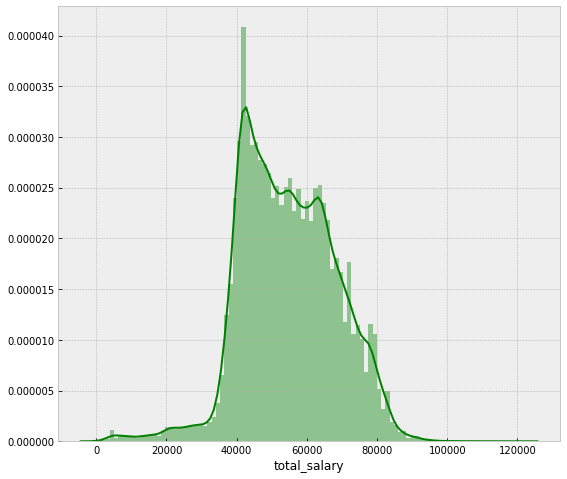

In [36]:
print(df['total_salary'].describe())
plt.figure(figsize=(9, 8))
#sns.distplot(df['total_salary'], color='g', bins=100);
sns.distplot(df['total_salary'], color='g', bins=100, hist_kws={'alpha': 0.4})

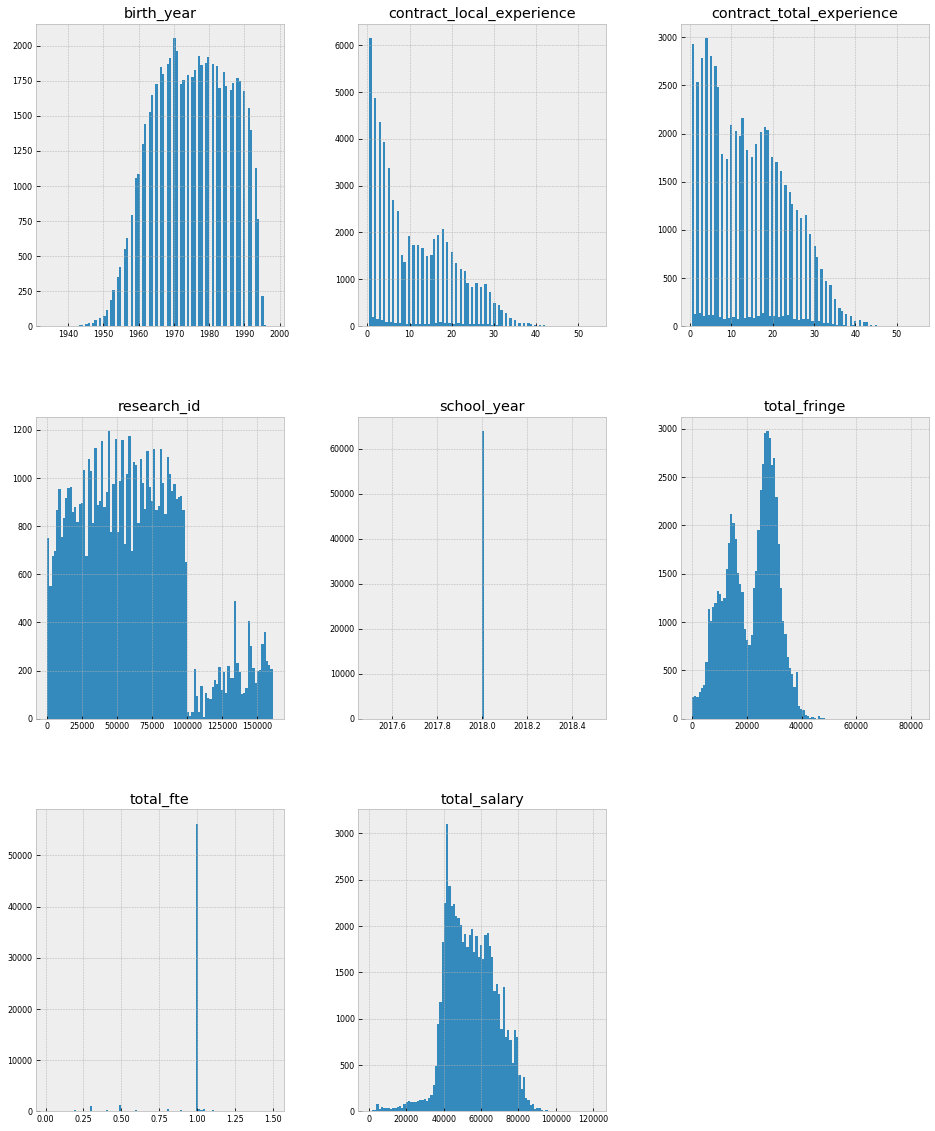

In [37]:
df.hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8);

In [38]:
df.corr()

,research_id,school_year,birth_year,contract_local_experience,contract_total_experience,total_salary,total_fringe,total_fte
research_id,1.000000,NaN,-0.140655,-0.025527,0.023707,0.012853,0.028137,-0.041174
school_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_year,-0.140655,NaN,1.000000,-0.658427,-0.770415,-0.527667,-0.279001,0.075782
contract_local_experience,-0.025527,NaN,-0.658427,1.000000,0.858488,0.640955,0.341532,0.002357
contract_total_experience,0.023707,NaN,-0.770415,0.858488,1.000000,0.652991,0.334481,-0.025700
total_salary,0.012853,NaN,-0.527667,0.640955,0.652991,1.000000,0.475361,0.228912
total_fringe,0.028137,NaN,-0.279001,0.341532,0.334481,0.475361,1.000000,0.216364
total_fte,-0.041174,NaN,0.075782,0.002357,-0.025700,0.228912,0.216364,1.000000


In [0]:
df_corr = df.corr()['total_salary'].drop('total_salary')

In [0]:
golden_features_list = df_corr[abs(df_corr) > 0.5].sort_values(ascending=False)

In [59]:
print("There is {} strongly correlated values with total_salary:\n{}".format(len(golden_features_list), golden_features_list))

There is 3 strongly correlated values with total_salary:
contract_total_experience    0.652991
contract_local_experience    0.640955
birth_year                  -0.527667
Name: total_salary, dtype: float64


In [61]:
for i in range(0, len(df.columns), 5):
    sns.pairplot(data=df,
                x_vars=df.columns[i:i+5],
                y_vars=['total_salary'])

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f85d3281d08> (for post_execute):


KeyboardInterrupt: ignored

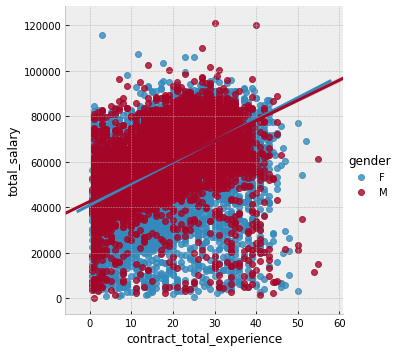

In [64]:
sns.lmplot(x="contract_total_experience",y="total_salary",hue="gender",data=df)

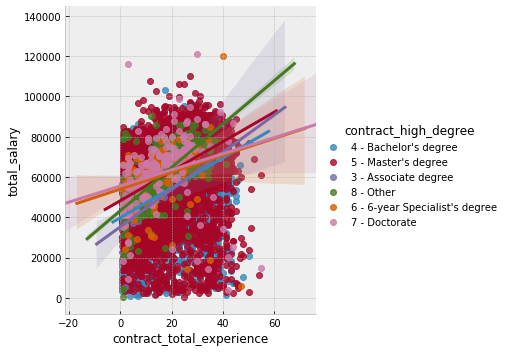

In [65]:
sns.lmplot(x="contract_total_experience",y="total_salary",hue="contract_high_degree",data=df)

In [0]:
query = '''
SELECT
  *
FROM
  [{project}.{dataset}.{table}]
WHERE
  assignment_work_school_level = '6 - Elementary School'
  AND assignment_work_agency = '6307 - West Bend School District'
  AND position_classification = 'Teachers'
  AND assignment_area = '0050 - Elementary - All Subjects'
LIMIT
  1000'''.format(project=project_id, dataset=dataset_name, table=table_name)

In [10]:
df = pd.io.gbq.read_gbq(query, project_id=project_id, reauth=True)
df['total_salary'] = df['total_salary'].apply(lambda x: convert_currency(x) if pd.notnull(x) else x)
df['total_fringe'] = df['total_fringe'].apply(lambda x: convert_currency(x) if pd.notnull(x) else x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


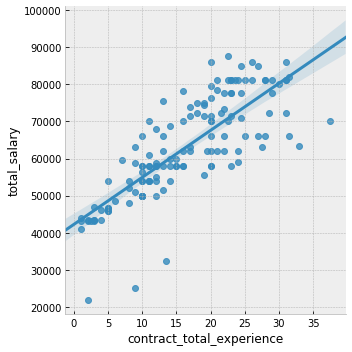

In [12]:
sns.lmplot(x="contract_total_experience",y="total_salary",data=df)